In [ ]:
!pip install -r requirements.txt

In [ ]:
!pip install torch

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import pandas as pd
from seqeval.metrics import f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import json
import random
import numpy as np

In [4]:
df = pd.read_csv('data/hw2_train.csv')
df.head()

,ID,utterances,IOB Slot tags
0,1,who plays luke on star wars new hope,O O B_char O B_movie I_movie I_movie I_movie
1,2,show credits for the godfather,O O O B_movie I_movie
2,3,who was the main actor in the exorcist,O O O O O O B_movie I_movie
3,4,find the female actress from the movie she 's ...,O O O O O O O B_movie I_movie I_movie I_movie
4,5,who played dory on finding nemo,O O B_char O B_movie I_movie


In [5]:
# Import necessary libraries
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('data/hw2_train.csv')

# Display the first few rows to confirm data structure
df.head()


,ID,utterances,IOB Slot tags
0,1,who plays luke on star wars new hope,O O B_char O B_movie I_movie I_movie I_movie
1,2,show credits for the godfather,O O O B_movie I_movie
2,3,who was the main actor in the exorcist,O O O O O O B_movie I_movie
3,4,find the female actress from the movie she 's ...,O O O O O O O B_movie I_movie I_movie I_movie
4,5,who played dory on finding nemo,O O B_char O B_movie I_movie


In [6]:
# Flatten the tags from all rows into a single list for counting
all_tags = [tag for tags in df['IOB Slot tags'].str.split() for tag in tags]

# Count occurrences of each tag
tag_counts = Counter(all_tags)
tag_counts_df = pd.DataFrame(tag_counts.items(), columns=['Tag', 'Count']).sort_values(by='Count', ascending=False)
tag_counts_df['Proportion'] = tag_counts_df['Count'] / tag_counts_df['Count'].sum()

# Display tag distribution table
tag_counts_df


,Tag,Count,Proportion
0,O,10505,0.721101
3,I_movie,1146,0.078666
2,B_movie,1016,0.069742
5,B_person,194,0.013317
7,B_director,185,0.012699
6,I_person,175,0.012013
8,I_director,168,0.011532
14,B_producer,164,0.011258
12,B_country,153,0.010502
21,B_mpaa_rating,141,0.009679


In [7]:
# Calculate token counts for each utterance
df['Token Count'] = df['utterances'].str.split().apply(len)

# Get summary statistics for token counts
token_count_stats = {
    "Mean": df['Token Count'].mean(),
    "Min": df['Token Count'].min(),
    "Max": df['Token Count'].max()
}

# Display token count statistics
token_count_stats


{'Mean': 6.307525951557094, 'Min': 1, 'Max': 21}

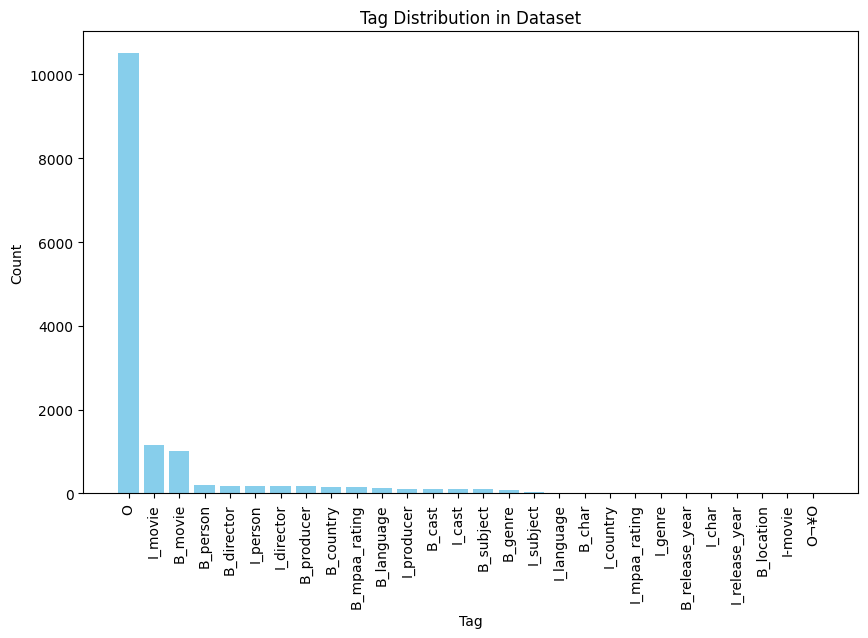

In [17]:
# Plot tag distribution
plt.figure(figsize=(10, 6))
plt.bar(tag_counts_df['Tag'], tag_counts_df['Count'], color='skyblue')
plt.xlabel('Tag')
plt.ylabel('Count')
plt.title('Tag Distribution in Dataset')
plt.xticks(rotation=90)
# save
plt.savefig('tag_distribution.png')
plt.show()


In [9]:
# Assuming separate files for splits, adjust file paths as needed
train_df = pd.read_csv('data/hw2_train.csv')
val_df = pd.read_csv('data/hw2_val.csv')
test_df = pd.read_csv('data/hw2_test.csv')

# Calculate number of samples in each split
split_counts = {
    "Train Set": len(train_df),
    "Validation Set": len(val_df),
    "Test Set": len(test_df)
}

# Calculate proportions
total_samples = sum(split_counts.values())
split_proportions = {key: count / total_samples for key, count in split_counts.items()}

# Display split counts and proportions
split_counts, split_proportions


FileNotFoundError: [Errno 2] No such file or directory: 'data/hw2_val.csv'

In [5]:
# Set seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)

In [156]:
# create if it doesn't exist
model_dir_name = "lstm_glove_unfrozen"

timestamp = pd.Timestamp.now().strftime('%m_%d_%H%M')
MODEL_DIR_NAME = f"model_{model_dir_name or timestamp}"

if not os.path.exists(MODEL_DIR_NAME):
    os.makedirs(MODEL_DIR_NAME)

### Documentation


In [7]:
def create_versioned_dir(base_dir):
    """ create a new versioned directory """
    os.makedirs(base_dir, exist_ok=True)
    existing_versions = [int(d[1:]) for d in os.listdir(base_dir) if d.startswith('v') and d[1:].isdigit()]
    version_num = max(existing_versions, default=0) + 1
    version_dir = os.path.join(base_dir, f'v{version_num}')
    os.makedirs(version_dir, exist_ok=True)
    return version_dir

In [8]:
def write_json(data, filename):
    with open(filename, 'w') as f:
        json.dump(data, f, indent=4)
    # print(f"Saved to {filename}")

In [104]:
from ctypes import BigEndianStructure
def get_config_json(embedding_dim, hidden_dim, batch_size, learning_rate, num_epochs, patience, dropout_prob, embedding_matrix_name, train_test_split, bidirectional, num_layers):
    return {
        "embedding_dim": embedding_dim,
        "hidden_dim": hidden_dim,
        "batch_size": batch_size,
        "learning_rate": learning_rate,
        "optimizer": "Adam",
        "epochs": num_epochs,
        "early_stopping_patience": patience,
        "dropout_prob": dropout_prob,
        "embedding_matrix": embedding_matrix_name,
        "train_test_split": train_test_split,
        "bidirectional": bidirectional,
        "num_layers": num_layers,
    }

In [10]:
def get_training_summary_json(train_losses, val_losses, val_f1_scores, early_stopping_epoch):
    return {
        "best_epoch": {
            "epoch": val_f1_scores.index(max(val_f1_scores)) + 1,
            "val_loss": val_losses[val_f1_scores.index(max(val_f1_scores))],
            "val_f1": max(val_f1_scores)
        },
        "early_stopping": {
            "epoch_triggered": early_stopping_epoch,
            "reason": "Early stopping triggered after epoch {}".format(early_stopping_epoch)
        },
        "epochs": [
            {"epoch": i + 1, "train_loss": train_losses[i], "val_loss": val_losses[i], "val_f1": val_f1_scores[i]}
            for i in range(len(train_losses))
        ]
    }

In [11]:
def get_val_results_json(true_tags, pred_tags, tag_names):
    # flatten the tags
    true_tags_flat = [tag for seq in true_tags for tag in seq]
    pred_tags_flat = [tag for seq in pred_tags for tag in seq]

    return {
        "true_tags": true_tags_flat,
        "predicted_tags": pred_tags_flat,
        "tag_names": tag_names
    }

In [12]:
def get_test_results_json(avg_test_loss, test_f1, test_report):
    return {
        "avg_test_loss": float(avg_test_loss),
        "f1_score": float(test_f1),
        "classification_report": test_report
    }

In [13]:
def save_performance_table(model_dir, true_tags, pred_tags):
    """ Save performance table to a CSV file """
    print(f"Saving performance table to '{model_dir}'")
    report = classification_report(true_tags, pred_tags, output_dict=True)
    df_report = pd.DataFrame(report).transpose().round(3)
    filepath = f"{model_dir}/performance_table.csv"
    df_report.to_csv(filepath)
    print(f"Performance table saved to '{filepath}'")

### Plots

In [14]:
def plot_loss_from_file(model_dir):
    # Load training summary data
    with open(f"{model_dir}/metrics.json", "r") as f:
        data = json.load(f)

    # Extract lists of training and validation losses
    train_losses = [entry["train_loss"] for entry in data["epochs"]]
    val_losses = [entry["val_loss"] for entry in data["epochs"]]
    epochs = range(1, len(train_losses) + 1)

    # Plot the loss curve
    plt.figure()
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()

    # Save plot to the model's directory
    plt.savefig(f"{model_dir}/loss_curve.png")
    # print(f"Loss curve saved to '{model_dir}/loss_curve.png'")
    plt.close()


In [15]:
def plot_f1_from_file(model_dir):
    # Load training summary data
    with open(f"{model_dir}/metrics.json", "r") as f:
        data = json.load(f)

    # Extract list of validation F1 scores
    val_f1_scores = [entry["val_f1"] for entry in data["epochs"]]
    epochs = range(1, len(val_f1_scores) + 1)

    # Plot the F1 score curve
    plt.figure()
    plt.plot(epochs, val_f1_scores, label='Validation F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.title('Validation F1 Score Over Epochs')
    plt.legend()

    # Save plot to the model's directory
    plt.savefig(f"{model_dir}/f1_curve.png")
    # print(f"F1 score curve saved to '{model_dir}/f1_curve.png'")
    plt.close()


In [16]:
def plot_confusion_matrix(model_dir):
    # Load test results data
    with open(f"{model_dir}/metrics/test_results.json", "r") as f:
        data = json.load(f)

    # Extract confusion matrix and tag names
    cm = data["confusion_matrix"]
    tag_names = data["tag_names"]

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=tag_names, yticklabels=tag_names)
    plt.xlabel('Predicted Tag')
    plt.ylabel('True Tag')
    plt.title('Confusion Matrix of Tag Predictions')

    # Save plot to the model's directory
    plt.savefig(f"{model_dir}/plots/confusion_matrix.png")
    # print(f"Confusion matrix saved to '{model_dir}/plots/confusion_matrix.png'")
    plt.close()


In [17]:
def plot_classification_report(model_dir):
    # Load test results data
    with open(f"{model_dir}/metrics/test_results.json", "r") as f:
        data = json.load(f)

    # Extract tag-specific F1 scores from the report
    report = data["classification_report"]
    tag_names = [tag for tag in report if tag not in ["accuracy", "macro avg", "weighted avg"]]
    f1_scores = [report[tag]["f1-score"] for tag in tag_names]

    # Plot F1 scores for each tag
    plt.figure(figsize=(10, 6))
    plt.barh(tag_names, f1_scores, color='skyblue')
    plt.xlabel('F1 Score')
    plt.title('Tag-wise F1 Score')

    # Save plot to the model's directory
    plt.savefig(f"{model_dir}/plots/classification_report.png")
    # print(f"Classification report plot saved to '{model_dir}/plots/classification_report.png'")
    plt.close()


### Pipeline

In [11]:
class SlotTaggingDataset(Dataset):
    def __init__(self, data, token_vocab=None, tag_vocab=None, training=True):
        # Create vocabularies if training
        if training:
            self.token_vocab = {'<PAD>': 0, '<UNK>': 1}
            self.tag_vocab = {'<PAD>': 0}

            # Build vocab from tokens and tags
            for _, row in data.iterrows():
                tokens = row['utterances'].split()
                tags = row['IOB Slot tags'].split() if 'IOB Slot tags' in row else None

                for token in tokens:
                    if token not in self.token_vocab:
                        self.token_vocab[token] = len(self.token_vocab)
                if tags:
                    for tag in tags:
                        if tag not in self.tag_vocab:
                            self.tag_vocab[tag] = len(self.tag_vocab)
        else:
            assert token_vocab is not None and tag_vocab is not None
            self.token_vocab = token_vocab
            self.tag_vocab = tag_vocab

        self.corpus_token_ids = [
            torch.tensor([self.token_vocab.get(token, self.token_vocab['<UNK>']) for token in row['utterances'].split()])
            for _, row in data.iterrows()
        ]

        # Only add tag ids if they exist
        if 'IOB Slot tags' in data.columns:
            self.corpus_tag_ids = [
                torch.tensor([self.tag_vocab[tag] for tag in row['IOB Slot tags'].split()])
                for _, row in data.iterrows()
            ]
        else:
            self.corpus_tag_ids = None

    def __len__(self):
        return len(self.corpus_token_ids)

    def __getitem__(self, idx):
        if self.corpus_tag_ids is not None:
            return self.corpus_token_ids[idx], self.corpus_tag_ids[idx]
        else:
            return self.corpus_token_ids[idx], idx

In [12]:
# Reverse the tag_vocab to map IDs back to tags
def ids_to_tags(tag_ids, tag_vocab):
    id_to_tag = {id_: tag for tag, id_ in tag_vocab.items()}
    return [[id_to_tag[id_] for id_ in seq] for seq in tag_ids]

In [13]:
# collate_fn with manually implemented padding
def collate_fn(batch):
    token_ids = [item[0] for item in batch]
    tag_ids = [item[1] for item in batch]

    # Calculate original lengths before padding
    lengths = [len(seq) for seq in token_ids]

    # Determine consistent max length for padding across both tokens and tags
    max_length = max(max(len(seq) for seq in token_ids), max(len(seq) for seq in tag_ids))

    # Manually pad each sequence in token_ids and tag_ids to max_length
    tokens_padded = torch.stack([
        F.pad(seq, (0, max_length - len(seq)), value=train_dataset.token_vocab['<PAD>']) for seq in token_ids
    ])
    tags_padded = torch.stack([
        F.pad(seq, (0, max_length - len(seq)), value=train_dataset.tag_vocab['<PAD>']) for seq in tag_ids
    ])

    assert tokens_padded.shape == tags_padded.shape, f"Padding mismatch: tokens {tokens_padded.shape}, tags {tags_padded.shape}"

    # print(f"tokens_padded shape: {tokens_padded.shape}, tags_padded shape: {tags_padded.shape}")
    return tokens_padded, tags_padded, lengths


In [14]:
TRAIN_VAL_TEST_SPLIT = "850/5/10"

df = pd.read_csv('data/hw2_train.csv')
df_train, df_valtest = train_test_split(df, test_size=0.15, random_state=42)
df_val, df_test = train_test_split(df_valtest, test_size=0.667, random_state=42)

train_dataset = SlotTaggingDataset(df_train, training=True)
val_dataset = SlotTaggingDataset(df_val, token_vocab=train_dataset.token_vocab, tag_vocab=train_dataset.tag_vocab, training=False)
test_dataset = SlotTaggingDataset(df_test, token_vocab=train_dataset.token_vocab, tag_vocab=train_dataset.tag_vocab, training=False)

tag_names = list(train_dataset.tag_vocab.keys())

In [16]:
split_counts = {
    "Train Set": len(df_train),
    "Validation Set": len(df_val),
    "Test Set": len(df_test)
}

# Calculate proportions
total_samples = sum(split_counts.values())
split_proportions = {key: count / total_samples for key, count in split_counts.items()}

# Display split counts and proportions
split_counts, split_proportions


({'Train Set': 1965, 'Validation Set': 115, 'Test Set': 232},
 {'Train Set': 0.8499134948096886,
  'Validation Set': 0.04974048442906574,
  'Test Set': 0.10034602076124567})

In [171]:
import numpy as np
import torch
import gensim.downloader as api

# load 100-dimensional GloVe embeddings
# glove = api.load('glove-wiki-gigaword-100')
glove = api.load('glove-wiki-gigaword-300')
EMBEDDING_DIM = 300

def create_embedding_matrix(vocab, word_vectors, embedding_dim=EMBEDDING_DIM):
    embedding_matrix = np.random.uniform(-0.1, 0.1, (len(vocab), embedding_dim))
    for word, idx in vocab.items():
        if word in word_vectors:
            embedding_matrix[idx] = word_vectors[word]
    return torch.tensor(embedding_matrix, dtype=torch.float)

# Create embedding matrix using the Gensim-preloaded embeddings
embedding_matrix = create_embedding_matrix(train_dataset.token_vocab, glove)

In [172]:
BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

In [173]:
class SlotTagger(nn.Module):
    def __init__(self, vocab_size, tagset_size, embedding_dim, hidden_dim, dropout_prob, pretrained_embeddings=None):
        super().__init__()

         # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        if pretrained_embeddings is not None:
            self.embedding.weight.data.copy_(torch.tensor(pretrained_embeddings))
            # self.embedding.weight.requires_grad = False  # Freeze embedding layer initially

        # self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        # self.rnn = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        # self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers=2, dropout=0.4, batch_first=True, bidirectional=True)
        BIDIRECTIONAL = True
        NUM_LAYERS = 1
        self.dropout = nn.Dropout(dropout_prob)  # Dropout layer with specified probability
        self.fc = nn.Linear(hidden_dim*2, tagset_size)
        self.tagset_size = tagset_size  # Added this for debug printout in forward

    def forward(self, token_ids, lengths):
        embeddings = self.embedding(token_ids)
        packed_embeds = pack_padded_sequence(embeddings, lengths, batch_first=True, enforce_sorted=False)

        packed_out, _ = self.rnn(packed_embeds)
        rnn_out, _ = pad_packed_sequence(packed_out, batch_first=True)
        rnn_out = self.dropout(rnn_out)

        # Verify rnn_out shape
        # print(f"rnn_out shape: {rnn_out.shape}. Should match (batch_size, {max(lengths)}, {self.rnn.hidden_size})")
        outputs = self.fc(rnn_out)
        # Check output shape
        # print(f"outputs shape: {outputs.shape}. Should be (batch_size, {max(lengths)}, {self.tagset_size})")

        assert outputs.shape == (len(token_ids), max(lengths), self.tagset_size), f"Output shape mismatch: {outputs.shape}"

        return outputs


In [174]:
# Define model, loss function, and optimizer
HIDDEN_DIM = 400
LEARNING_RATE = 0.00017
DROPOUT_PROB = 0.4

NUM_EPOCHS = 200
PATIENCE = 9

# initialize model, loss function, and optimizer
model = SlotTagger(
    vocab_size=len(train_dataset.token_vocab),
    tagset_size=len(train_dataset.tag_vocab),
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    dropout_prob=DROPOUT_PROB,
    pretrained_embeddings=embedding_matrix
)
loss_fn = nn.CrossEntropyLoss(ignore_index=train_dataset.tag_vocab['<PAD>'])
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

<ipython-input-173-957a98540624>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.embedding.weight.data.copy_(torch.tensor(pretrained_embeddings))


In [175]:
version_dir = create_versioned_dir(MODEL_DIR_NAME)

# Training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

epochs_no_improve = 0
best_val_loss = float('inf')
best_val_f1 = 0
best_model_state = None

# initialize lists to track metrics across epochs
train_losses = []
val_losses = []
val_f1_scores = []

for epoch in range(NUM_EPOCHS):
    model.train()
    total_train_loss = 0

    for batch_idx, (token_ids, tag_ids, lengths) in enumerate(train_loader):
        token_ids, tag_ids = token_ids.to(device), tag_ids.to(device)
        optimizer.zero_grad()
        outputs = model(token_ids, lengths)

        # Normal way to flatten outputs and tags to calculate loss
        loss = loss_fn(outputs.view(-1, outputs.shape[-1]), tag_ids.view(-1))
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    # Average train loss for epoch
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # VALIDATION
    model.eval()
    total_val_loss = 0
    all_preds = []
    all_true_tags = []

    with torch.no_grad():
        for token_ids, tag_ids, lengths in val_loader:  # Use val_loader here
            token_ids, tag_ids = token_ids.to(device), tag_ids.to(device)

            outputs = model(token_ids, lengths)
            loss = loss_fn(outputs.view(-1, outputs.shape[-1]), tag_ids.view(-1))
            total_val_loss += loss.item()

            # Get the predicted tag IDs by taking argmax over the last dimension
            predicted_tag_ids = outputs.argmax(dim=-1).cpu().tolist()
            true_tag_ids = tag_ids.cpu().tolist()

            # Mask out <PAD> tokens from predictions and true tags
            masked_predictions = []
            masked_true_tags = []

            for i, length in enumerate(lengths):
                masked_predictions.append(predicted_tag_ids[i][:length])  # Trim predictions to actual length
                masked_true_tags.append(true_tag_ids[i][:length])  # Trim true tags to actual length

            # Convert ID sequences to tag names
            masked_predictions = ids_to_tags(masked_predictions, train_dataset.tag_vocab)
            masked_true_tags = ids_to_tags(masked_true_tags, train_dataset.tag_vocab)

            # Accumulate all predictions and true tags for F1 calculation
            all_preds.extend(masked_predictions)
            all_true_tags.extend(masked_true_tags)

    # Calculate average validation loss
    avg_val_loss = total_val_loss / len(val_loader)
    val_f1 = f1_score(all_true_tags, all_preds)

    # Store metrics for plotting
    val_losses.append(avg_val_loss)
    val_f1_scores.append(val_f1)

    is_best = val_f1 > best_val_f1 or (val_f1 == best_val_f1 and avg_val_loss < best_val_loss)

    print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.3f}, Val Loss: {avg_val_loss:.3f}, Val F1: {val_f1:.3f} {"*" if is_best else {epochs_no_improve+1}}')

    # EARLY STOPPING LOGIC
    if val_f1 > best_val_f1 or (val_f1 == best_val_f1 and avg_val_loss < best_val_loss):
        # Update best metrics and model state
        best_val_loss = avg_val_loss
        best_val_f1 = val_f1
        epochs_no_improve = 0
        best_model_state = model.state_dict()  # Save the best model's state
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print(f"Early stopping triggered at epoch {epoch+1}. Best val F1: {best_val_f1:.3f} at Val Loss: {best_val_loss:.3f}")

            # Load the best model state before breaking
            model.load_state_dict(best_model_state)

            # Save training and validation metrics
            training_summary = get_training_summary_json(train_losses, val_losses, val_f1_scores, epoch)
            val_results = get_val_results_json(all_true_tags, all_preds, tag_names)
            config = get_config_json(
                embedding_dim=EMBEDDING_DIM,
                hidden_dim=HIDDEN_DIM,
                batch_size=BATCH_SIZE,
                learning_rate=LEARNING_RATE,
                num_epochs=NUM_EPOCHS,
                patience=PATIENCE,
                dropout_prob=DROPOUT_PROB,
                embedding_matrix_name="GloVe",
                train_test_split=TRAIN_VAL_TEST_SPLIT,
                bidirectional=True,
                num_layers=2
            )
            write_json(config, f"{version_dir}/config.json")
            write_json(training_summary, f"{version_dir}/metrics.json")
            write_json(val_results, f"{version_dir}/val_results.json")
            plot_f1_from_file(version_dir)
            plot_loss_from_file(version_dir)
            break


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_movie seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: I_movie seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_country seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: <PAD> seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_mpaa_rating seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/seq

Epoch 1, Train Loss: 2.525, Val Loss: 1.294, Val F1: 0.000 *
Epoch 2, Train Loss: 1.163, Val Loss: 1.067, Val F1: 0.107 *
Epoch 3, Train Loss: 1.013, Val Loss: 0.964, Val F1: 0.103 {1}
Epoch 4, Train Loss: 0.904, Val Loss: 0.861, Val F1: 0.145 *
Epoch 5, Train Loss: 0.767, Val Loss: 0.733, Val F1: 0.189 *
Epoch 6, Train Loss: 0.637, Val Loss: 0.616, Val F1: 0.375 *
Epoch 7, Train Loss: 0.518, Val Loss: 0.515, Val F1: 0.528 *
Epoch 8, Train Loss: 0.420, Val Loss: 0.448, Val F1: 0.523 {1}
Epoch 9, Train Loss: 0.347, Val Loss: 0.383, Val F1: 0.561 *
Epoch 10, Train Loss: 0.295, Val Loss: 0.338, Val F1: 0.649 *
Epoch 11, Train Loss: 0.253, Val Loss: 0.305, Val F1: 0.672 *
Epoch 12, Train Loss: 0.222, Val Loss: 0.288, Val F1: 0.675 *
Epoch 13, Train Loss: 0.196, Val Loss: 0.262, Val F1: 0.672 {1}
Epoch 14, Train Loss: 0.175, Val Loss: 0.238, Val F1: 0.695 *
Epoch 15, Train Loss: 0.160, Val Loss: 0.224, Val F1: 0.712 *
Epoch 16, Train Loss: 0.144, Val Loss: 0.211, Val F1: 0.726 *
Epoch 17, T

In [ ]:
# # Grid search
# import itertools

# # Define grid of hyperparameters
# dropout_options = [0.25, 0.3, 0.35]
# lr_options = [0.0008, 0.001, 0.0015]
# hidden_dim_options = [512]

# # Generate all possible combinations of hyperparameters
# param_grid = list(itertools.product(dropout_options, lr_options, hidden_dim_options))



# def grid_search(param_grid, model_dir):
#     results = []

#     for trial, (dropout, learning_rate, hidden_dim) in enumerate(param_grid, start=1):
#         print(f"\nStarting Trial {trial}/{len(param_grid)} with Dropout: {dropout}, LR: {learning_rate}, Hidden Dim: {hidden_dim}")

#         # Run training and evaluation with these hyperparameters
#         val_loss, val_f1 = train_and_evaluate(dropout, learning_rate, hidden_dim, model_dir=model_dir)

#         # Record results
#         trial_result = {
#             "dropout": dropout,
#             "learning_rate": learning_rate,
#             "hidden_dim": hidden_dim,
#             "val_loss": val_loss,
#             "val_f1": val_f1
#         }
#         results.append(trial_result)

#         print(f"Trial {trial} complete: Val Loss: {val_loss:.3f}, Val F1: {val_f1:.3f}")

#     return results

# # Run grid search over all combinations
# search_results = grid_search(param_grid, "model_rnn_dropout_with_glove/grid_search_around_top")

# search_results_df = pd.DataFrame(search_results)
# search_results_df.sort_values('val_f1', ascending=False, inplace=True)
# search_results_df.reset_index(drop=True, inplace=True)
# search_results_df.to_csv(f"model_rnn_dropout_with_glove/grid_search_around_top/grid_search_results.csv", index=False)

# search_results_df

In [176]:
# Test (validation) loop encapsulated

model.eval()
total_test_loss = 0
all_preds = []
all_true_tags = []

with torch.no_grad():
    for token_ids, tag_ids, lengths in test_loader:
        token_ids, tag_ids = token_ids.to(device), tag_ids.to(device)

        # Get model outputs and calculate loss
        outputs = model(token_ids, lengths)
        loss = loss_fn(outputs.view(-1, outputs.shape[-1]), tag_ids.view(-1))
        total_test_loss += loss.item()

        # Get predicted and true tag IDs
        predicted_tag_ids = outputs.argmax(dim=-1).cpu().tolist()
        true_tag_ids = tag_ids.cpu().tolist()

        # Trim predictions and true tags to match actual lengths
        masked_predictions = [pred[:length] for pred, length in zip(predicted_tag_ids, lengths)]
        masked_true_tags = [true[:length] for true, length in zip(true_tag_ids, lengths)]

        # Convert ID sequences to tag names
        masked_predictions = ids_to_tags(masked_predictions, train_dataset.tag_vocab)
        masked_true_tags = ids_to_tags(masked_true_tags, train_dataset.tag_vocab)

        # Accumulate all predictions and true tags for F1 calculation
        all_preds.extend(masked_predictions)
        all_true_tags.extend(masked_true_tags)

avg_test_loss = total_test_loss / len(test_loader)
test_f1 = f1_score(all_true_tags, all_preds)
report = classification_report(all_true_tags, all_preds)

print(f"Test F1 Score: {test_f1:.3f} | Test Loss: {avg_test_loss:.3f}")

# Save results
test_results = get_test_results_json(avg_test_loss, test_f1, report)

write_json(test_results, f"{version_dir}/test_results.json")
save_performance_table(MODEL_DIR_NAME, all_true_tags, all_preds)

Test F1 Score: 0.870 | Test Loss: 0.152
Saving performance table to 'model_lstm_glove_unfrozen'
Performance table saved to 'model_lstm_glove_unfrozen/performance_table.csv'


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_location seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_release_year seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
plot_loss_from_file(MODEL_DIR_NAME)
plot_f1_from_file(MODEL_DIR_NAME)
plot_confusion_matrix(MODEL_DIR_NAME)

In [38]:
# Debug function

def display_sample_outputs(model, data_loader, token_vocab, tag_vocab, n_samples=5):
    model.eval()
    samples = []

    id_to_token = {id_: token for token, id_ in token_vocab.items()}
    id_to_tag = {id_: tag for tag, id_ in tag_vocab.items()}

    with torch.no_grad():
        for token_ids, tag_ids, lengths in data_loader:
            token_ids, tag_ids = token_ids.to(device), tag_ids.to(device)
            outputs = model(token_ids, lengths)
            predicted_tag_ids = outputs.argmax(dim=-1).cpu().tolist()
            true_tag_ids = tag_ids.cpu().tolist()

            for i in range(min(n_samples, len(token_ids))):
                tokens = [id_to_token[id_] for id_ in token_ids[i].cpu().tolist()]
                true_tags = [id_to_tag[id_] for id_ in true_tag_ids[i]]
                pred_tags = [id_to_tag[id_] for id_ in predicted_tag_ids[i]]
                samples.append((tokens, true_tags, pred_tags))
            break  # Only get samples from the first batch for inspection

    # Display the collected samples
    for i, (tokens, true_tags, pred_tags) in enumerate(samples):
        print(f"Sample {i + 1}:")
        print("Tokens:    ", tokens)
        print("True Tags: ", true_tags)
        print("Pred Tags: ", pred_tags)
        print("\n")

# Run this with both vocabularies on the test loader
display_sample_outputs(model, test_loader, train_dataset.token_vocab, train_dataset.tag_vocab)


Sample 1:
Tokens:     ['alfred', 'hitchcock', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
True Tags:  ['B_person', 'I_person', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
Pred Tags:  ['B_director', 'I_director', 'B_movie', 'B_movie', 'B_movie', 'B_movie', 'B_movie', 'B_movie', 'B_movie', 'B_movie']


Sample 2:
Tokens:     ['find', 'producer', 'of', 'the', 'great', '<UNK>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
True Tags:  ['O', 'O', 'O', 'B_movie', 'I_movie', 'I_movie', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
Pred Tags:  ['O', 'O', 'O', 'B_movie', 'I_movie', 'I_movie', 'B_movie', 'B_movie', 'B_movie', 'B_movie']


Sample 3:
Tokens:     ['show', 'me', 'a', 'list', 'of', 'movies', 'with', 'r', 'rating', '<PAD>']
True Tags:  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B_mpaa_rating', 'O', '<PAD>']
Pred Tags:  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B_mpaa_rating', 'O', 'B_movie']


Sample 4:
Tokens:     ['pg', 'movies', 'list', 'please', '<PAD>', '<

### Inference

In [177]:
import torch.nn.functional as F

def collate_fn_inference(batch):
    token_ids = [item[0] for item in batch]

    # Calculate original lengths before padding
    lengths = [len(seq) for seq in token_ids]

    # Determine max length for consistent padding across all sequences in the batch
    max_length = max(len(seq) for seq in token_ids)

    # Manually pad each sequence in token_ids to max_length
    tokens_padded = torch.stack([
        F.pad(seq, (0, max_length - len(seq)), value=train_dataset.token_vocab['<PAD>']) for seq in token_ids
    ])

    return tokens_padded, lengths


In [178]:
# Load the unseen test data
unseen_test_df = pd.read_csv('data/hw2_test.csv')

# Create the unseen test dataset
unseen_test_dataset = SlotTaggingDataset(
    unseen_test_df,
    token_vocab=train_dataset.token_vocab,
    tag_vocab=train_dataset.tag_vocab,
    training=False
)

# Create a DataLoader for the unseen test set
unseen_test_loader = DataLoader(
    unseen_test_dataset,
    batch_size=32,
    shuffle=False,
    collate_fn=collate_fn_inference
)

In [179]:
# Run inference on the Kaggle test data
model.eval()
all_preds_raw = []
all_preds = []

with torch.no_grad():
    for token_ids, lengths in unseen_test_loader:
        token_ids = token_ids.to(device)

        # Get model outputs
        outputs = model(token_ids, lengths)
        predicted_tag_ids = outputs.argmax(dim=-1).cpu().tolist()

        # Trim predictions to match actual sequence lengths
        trimmed_predictions = [pred[:length] for pred, length in zip(predicted_tag_ids, lengths)]

        for i, length in enumerate(lengths):
            print(f"Prediction: {len(predicted_tag_ids[i])} | Expecteded: {length} | Trimmed: {len(trimmed_predictions[i])}")

        # Convert ID sequences to tag names
        trimmed_tags = ids_to_tags(trimmed_predictions, train_dataset.tag_vocab)

        # Collect predictions for all batches
        all_preds.extend(trimmed_tags)

        # Collect raw predictions for debugging
        raw_tags = ids_to_tags(predicted_tag_ids, train_dataset.tag_vocab)
        all_preds_raw.extend(raw_tags)

Prediction: 16 | Expecteded: 3 | Trimmed: 3
Prediction: 16 | Expecteded: 7 | Trimmed: 7
Prediction: 16 | Expecteded: 8 | Trimmed: 8
Prediction: 16 | Expecteded: 4 | Trimmed: 4
Prediction: 16 | Expecteded: 4 | Trimmed: 4
Prediction: 16 | Expecteded: 3 | Trimmed: 3
Prediction: 16 | Expecteded: 6 | Trimmed: 6
Prediction: 16 | Expecteded: 7 | Trimmed: 7
Prediction: 16 | Expecteded: 6 | Trimmed: 6
Prediction: 16 | Expecteded: 6 | Trimmed: 6
Prediction: 16 | Expecteded: 6 | Trimmed: 6
Prediction: 16 | Expecteded: 5 | Trimmed: 5
Prediction: 16 | Expecteded: 6 | Trimmed: 6
Prediction: 16 | Expecteded: 11 | Trimmed: 11
Prediction: 16 | Expecteded: 16 | Trimmed: 16
Prediction: 16 | Expecteded: 5 | Trimmed: 5
Prediction: 16 | Expecteded: 4 | Trimmed: 4
Prediction: 16 | Expecteded: 3 | Trimmed: 3
Prediction: 16 | Expecteded: 7 | Trimmed: 7
Prediction: 16 | Expecteded: 3 | Trimmed: 3
Prediction: 16 | Expecteded: 8 | Trimmed: 8
Prediction: 16 | Expecteded: 4 | Trimmed: 4
Prediction: 16 | Expecteded:

In [180]:
# Prepare the predictions for submission
submission = pd.DataFrame({
    'ID': unseen_test_df['ID'],
    'IOB Slot tags': [' '.join(tags) for tags in all_preds]
})

# Save submission file
submission.to_csv(f'{version_dir}/submission.csv', index=False)
print("Submission file saved as 'submission.csv'")

# Debugging submission
submission_debug = pd.DataFrame({
    'ID': unseen_test_df['ID'],
    'utterances': unseen_test_df['utterances'],
    'IOB Slot tags': [' '.join(tags) for tags in all_preds],
    'IOB Slot tags Raw': [' '.join(tags) for tags in all_preds_raw]
})

submission_debug.to_csv(f'{version_dir}/submission_debug.csv', index=False)
print("Debugging submission file saved as 'submission_debug.csv'")

Submission file saved as 'submission.csv'
Debugging submission file saved as 'submission_debug.csv'


#### Plots